In [1]:
%load_ext autoreload
%autoreload 2

In [372]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functions.hyperloglog import HashLogLog, HyperLogLog
from functions.clustering import KMeansClustering, elbow_method, plot_wordclouds, reviews_per_cluster, plot_distributions, uniqueusers_per_cluster, wordcloud_comparison
from functions.data_preprocess import remove_html_tags, preprocess, tfidf_svd, lemmatization

# 1. Hashing

## Sequentially adding data to the HLL
## What is HyperLogLog?
The implementation of the HyperLogLog algorithm is based on the [paper](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf) published by Flajolet et al. in 2007, where they present and explain a strategy to approximate the number of of distinct element in a multiset. In short, the basis of the HyperLogLog algorithm is the observation that the cardinality of a multiset of uniformly distributed random numbers can be estimated by calculating the maximum number of leading zeros in the binary representation of each number in the set. If the maximum number of leading zeros observed is $n$, an estimate for the number of distinct elements in the set is $2^n$. In order to obtain a uniformely distributed random numbers, the algorithm proposes to use a hash function on the original multiset.
## The hash function
As we just observed, we need use one hash function on the original set. We decided to implement a universal family of hashing functions, basing our rationale on the work by Carter et al. on the paper [Universal classes of hash functions](https://www.sciencedirect.com/science/article/pii/0022000079900448?via%3Dihub). In particular, we coded the hash function defined by the modulo operation. Let's give some details about it!

We randomly pick a hash function from a family of hashing functions
$$H = \{h: U \to [m]\}$$
that maps our universe $U$ to a set of dimension $m$. The hashing functions family we defined is, as we already said, the following:
$$h_{a, b}(x) = ((ax + b) \mod p) \mod m$$
where $p$ is a prime s.t. $p \ge m$ and $a$ and $b$ are randomly chosen integers s.t. $a \ne 0$ and both lower than $p$.

## Our choices
Once we have the hashing function, we need to choose the dimension of the arriving space for the hashing function 

In [2]:
log2m = 6
bits = 32

HLL_6 = HyperLogLog(log2m=log2m, bits=bits)

hll_6 = HLL_6.structure('hash.txt')

print(hll_6)

[23, 21, 23, 21, 23, 25, 22, 23, 23, 20, 21, 23, 21, 20, 22, 22, 21, 26, 20, 21, 26, 22, 21, 22, 22, 22, 20, 22, 25, 23, 26, 22, 24, 21, 21, 21, 21, 20, 20, 21, 24, 21, 24, 25, 22, 21, 25, 25, 25, 22, 20, 24, 22, 26, 20, 24, 24, 26, 21, 26, 20, 25, 22, 21]


## Cardinality and (relative) error of the filter

In [3]:
estimate_6 = HLL_6.cardinality(hll_6)
error_6 = HLL_6.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {}'.format(estimate_6, error_6))

Total bits: 32
Bits for the buckets: 6
Estimate: 139604896
Error: 0.13


### Observation
Maybe we can do a little bit better by increasing the lenght of the root to 11 bits. This seems to be a good point for the tradeoff between error and efficiency!

In [4]:
log2m, bits = 11, 32

HLL_11 = HyperLogLog(log2m=log2m, bits=bits)

hll_11 = HLL_11.structure('hash.txt')

estimate_11 = HLL_11.cardinality(hll_11)

error_11 = HLL_11.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {:.3f}'.format(estimate_11, error_11))

Total bits: 32
Bits for the buckets: 11
Estimate: 123189077
Error: 0.023


# Real error
To compute the real error of the algorithm we used, we have to count the exact number of unique elements that appear in the `hash.txt` file. In order to do that, there are severel options. One of those is to use shell commands, and that's what we've chosen to do.

In [5]:
!sort hash.txt | uniq | wc -l

125000000


# 2. Clustering

## 2.0 Preprocess data

### Data cleaning

In [485]:
data_path = './data/Reviews.csv'

data = pd.read_csv(data_path, index_col=False)

In [506]:
# Preprocess data
data['Text'] = data['Text'].apply(preprocess)
data['Text'] = data['Text'].apply(keep_nouns)
data['LemmatizedText'] = data['Text'].apply(lemmatization)
data = data[data['Text'] != '']

data = data.reset_index().drop(columns={'index', 'Id'})
data.to_csv('./data/clean_data.csv')

### Tf-idf representation and dimensionality reduction

In [99]:
data = pd.read_csv('./data/clean_data.csv', index_col=False)

In [103]:
data_reduced = tfidf_svd(data['LemmatizedText'])
data_reduced.shape

(566411, 17)

### Elbow method and KMeans clustering

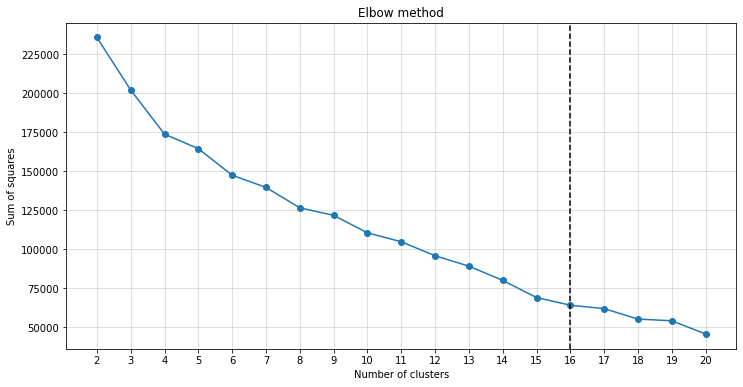

In [30]:
elbow_method(data_reduced, max_cluster_n=20)

In [332]:
n_clusters = 16
model = KMeansClustering(n_clusters=n_clusters)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster'] = cluster_labels

### Wordcloud representation of the clusters

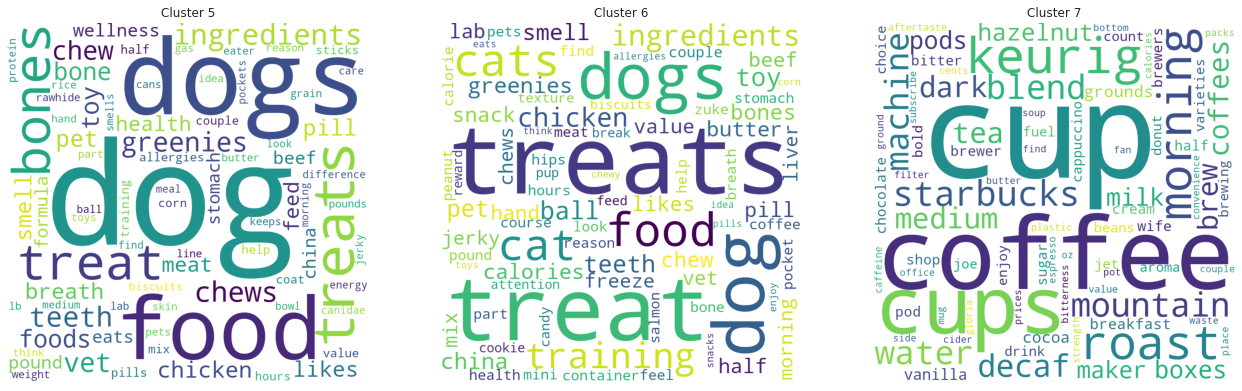

In [375]:
plot_wordclouds(data, clusters=[5, 6, 7])

In [337]:
n_clusters = 16
model = KMeans(n_clusters=n_clusters)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster_sklearn'] = cluster_labels

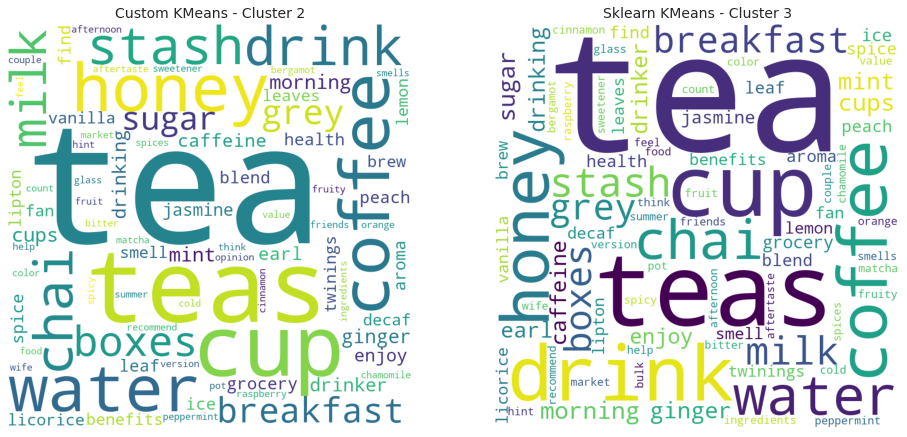

In [377]:
wordcloud_comparison(data, cluster=2)

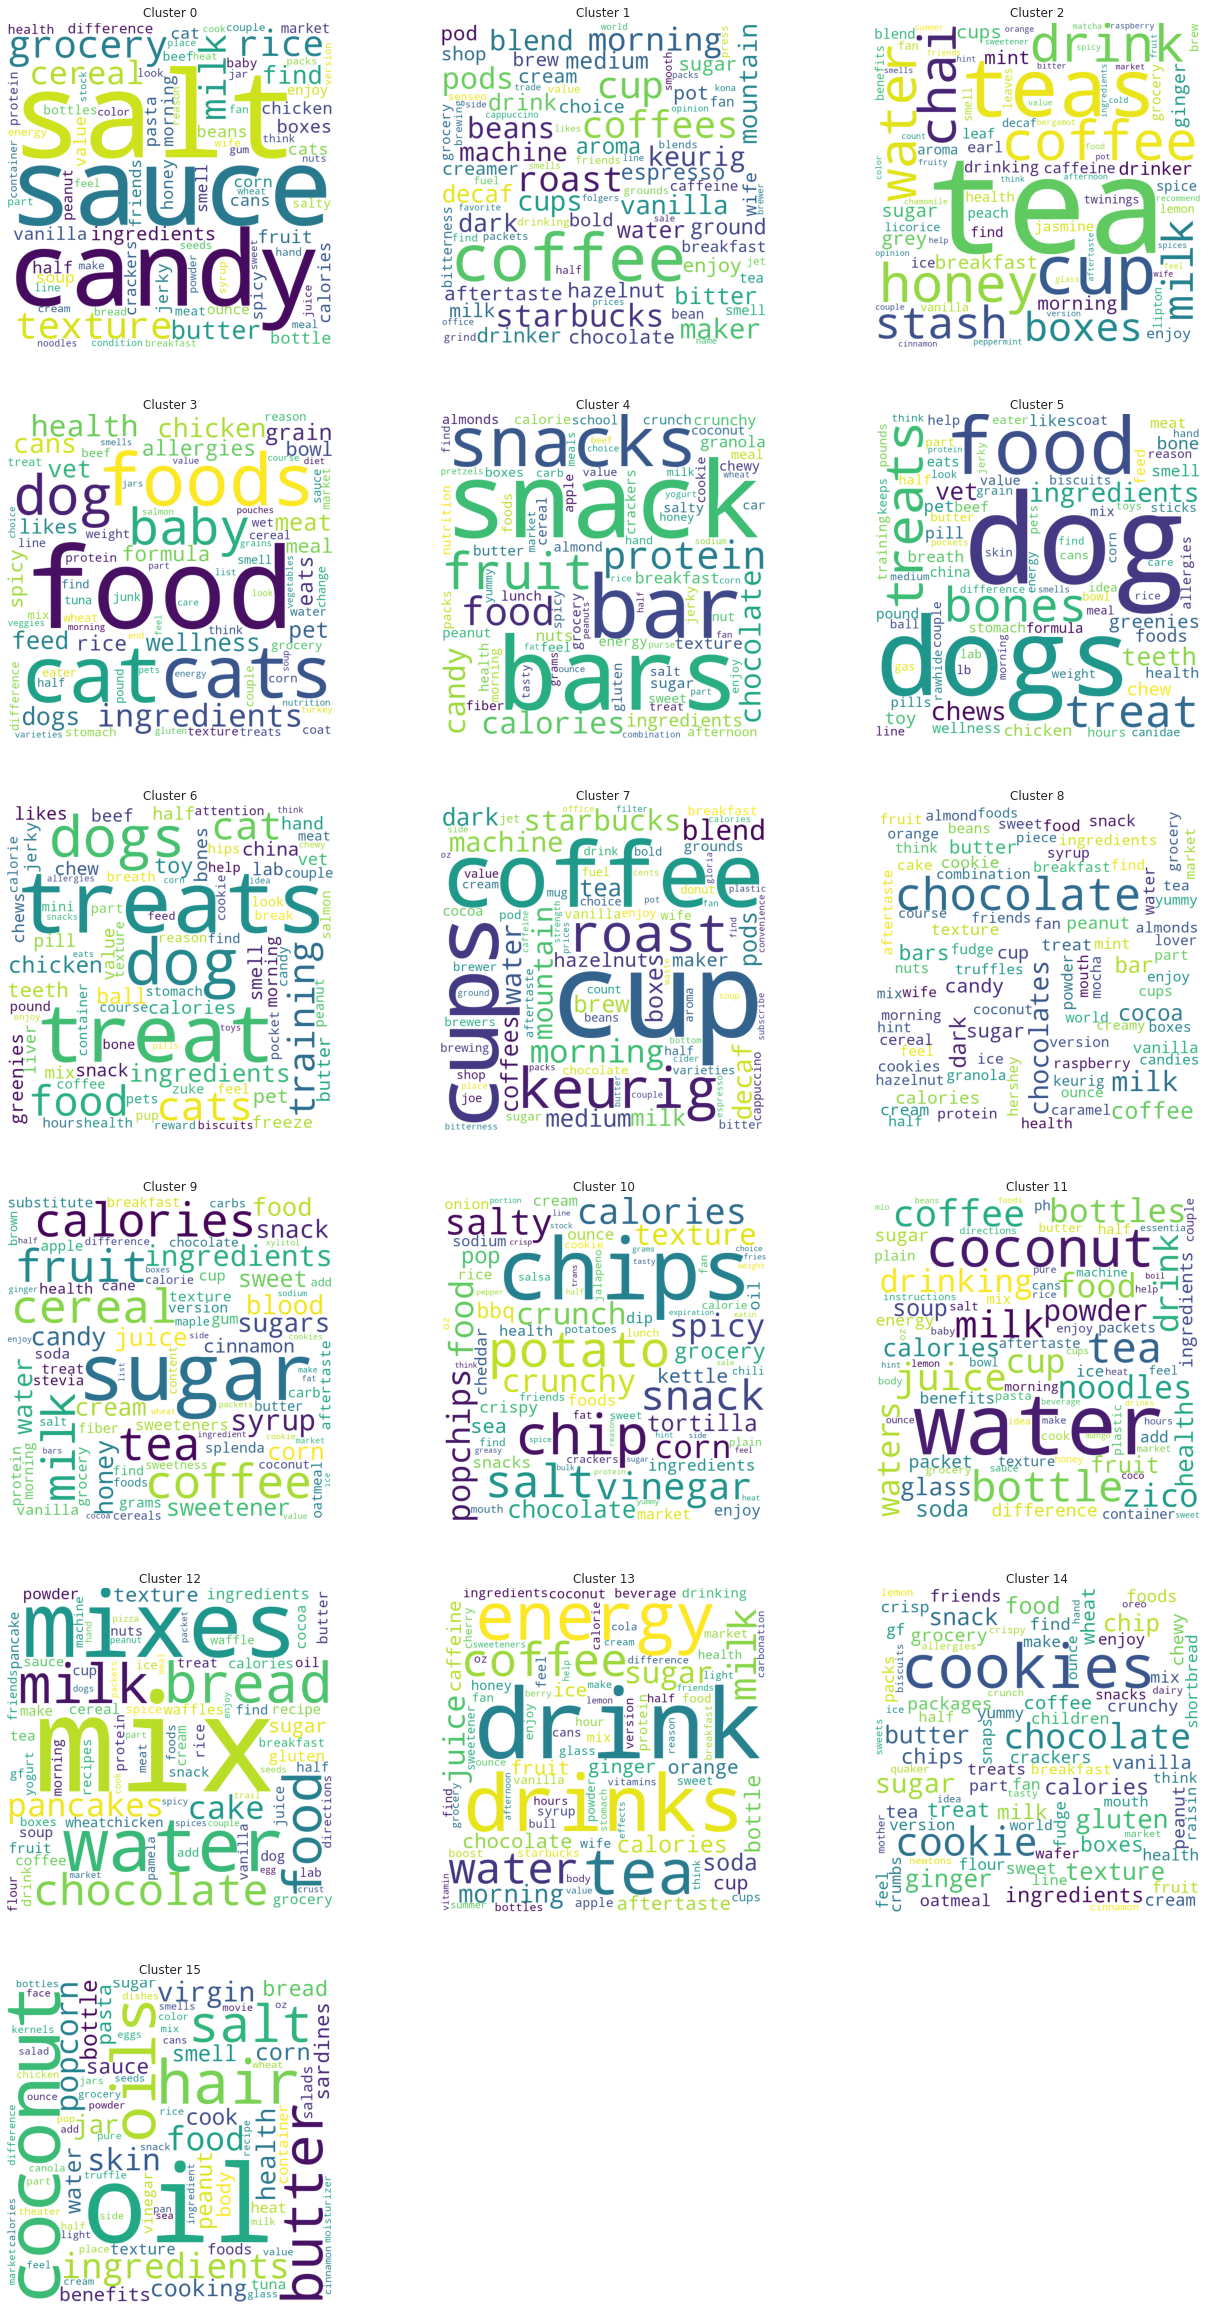

In [371]:
plot_wordclouds(data, clusters=range(n_clusters))

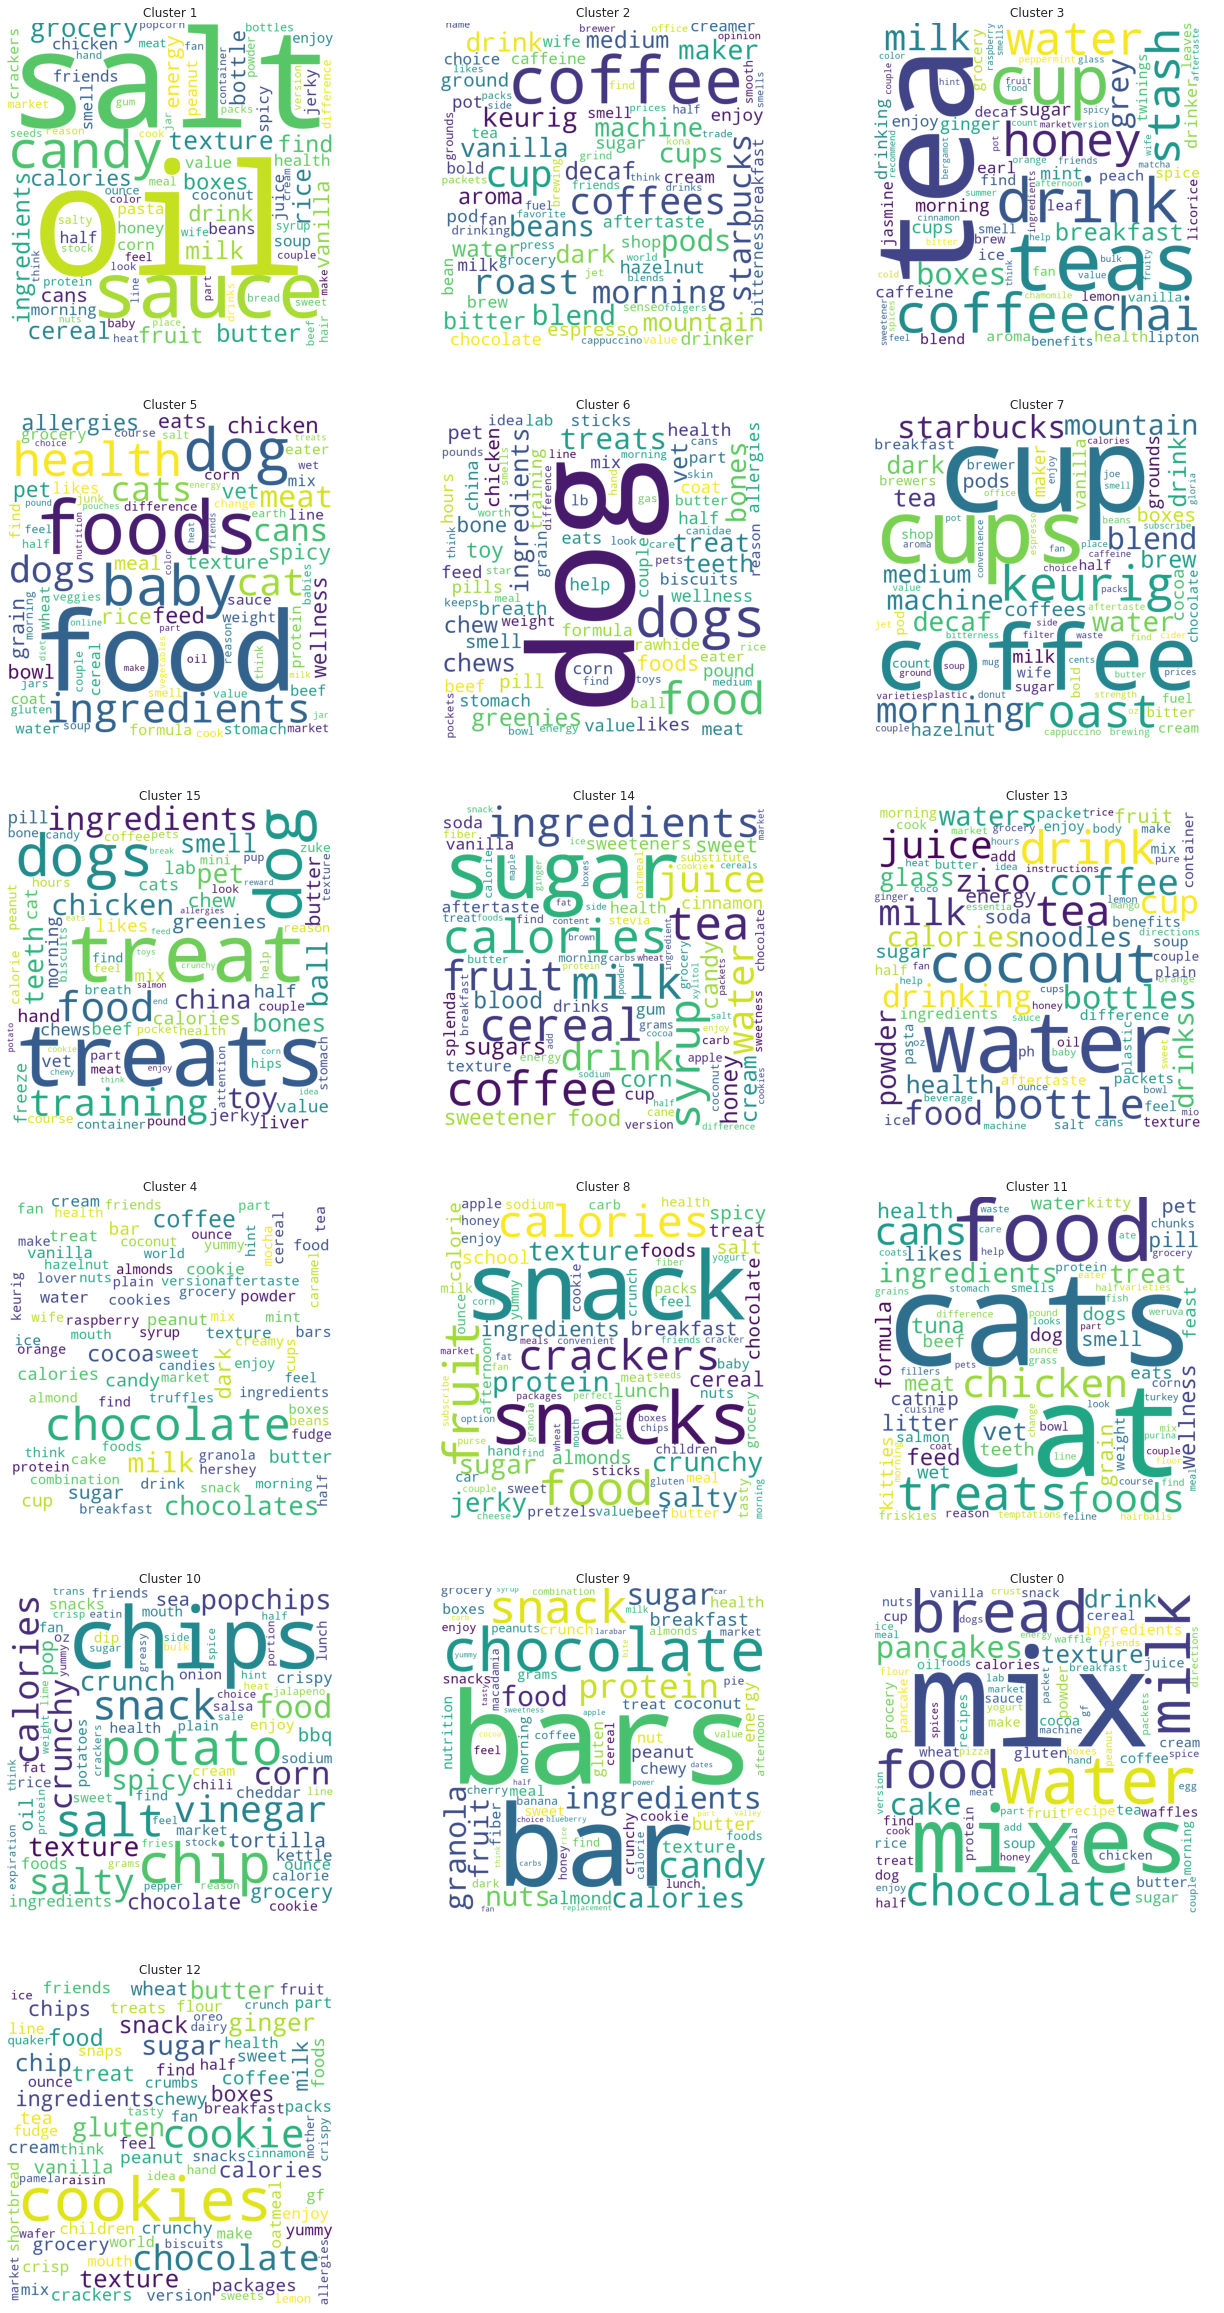

In [370]:
plot_wordclouds(data, clusters=clusters_, cluster_col='Cluster_sklearn')

### Number of elements in each cluster

In [154]:
reviews_per_cluster(data)

Cluster  Reviews Number
0         0           45688
1         1           38920
2         2           21726
3         3           17056
4         4           12878
5         5           26304
6         6           13322
7         7           16922
8         8           29533
9         9           18685
10       10           15927
11       11          222236
12       12           14402
13       13           39314
14       14           13038
15       15           20460

### Distribution of the score for each cluster

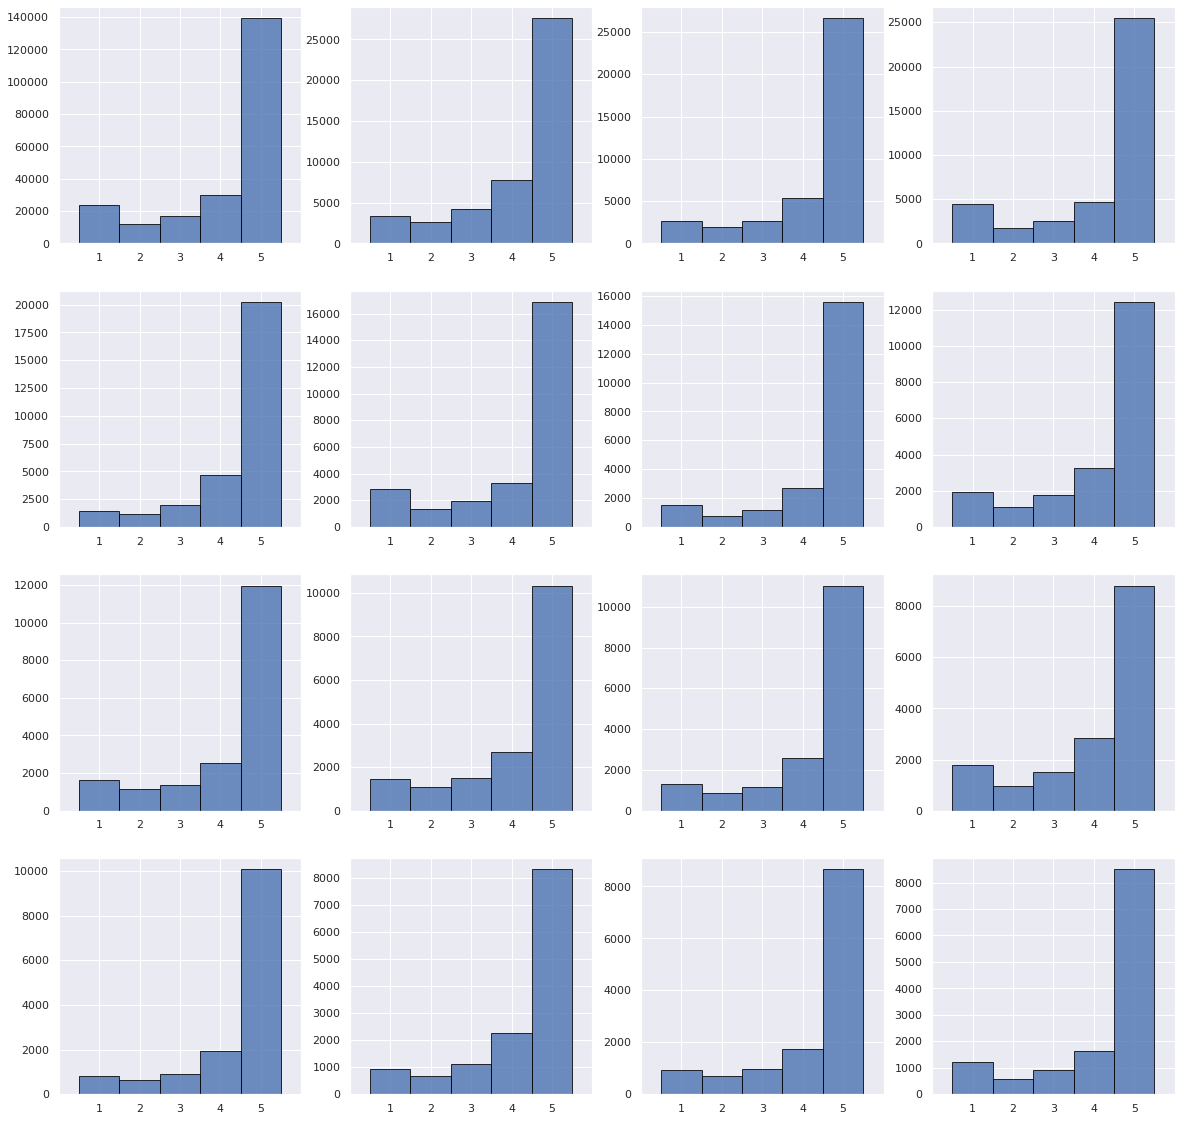

In [378]:
plot_distributions(data)

#### Observation
The previous plots are self explanatory: there isn't really that much of a change between each cluster in terms of score values. In fact, we can observe that all the clusters have the same behaviour: the vast majority of the users give a full score to the products they review; then, a great part of the remaining reviews have a 4 stars score. Finally, the last remaining part is almost equally distributed among the remaining scores: 1, 2 and 3 stars.

This kind of pattern is also observable from the mean and standard deviation of the cluster score distribution. In fact, we can see that the mean value is always around 4 stars, and the standard deviation never exceed 1.4.

There are probably two explanations for this behaviour: the first one is that users, most of the time, don't really bother in reviewing a product unless they're really happy. Moreover, it is much easier to just say that the product "is good", compared to give an actual score to it (i.e., why bother in selecting a score if you can just say: "5 stars, good; 1 star, not good"?).

In [379]:
data.groupby('Cluster').agg({'Score':['mean','std']})

Score          
             mean       std
Cluster                    
0        4.119495  1.368070
1        4.171424  1.253266
2        4.309483  1.203522
3        4.152852  1.382124
4        4.393255  1.092572
5        4.143020  1.366775
6        4.381202  1.183603
7        4.133480  1.315265
8        4.182553  1.308502
9        4.136257  1.302442
10       4.252807  1.245961
11       3.999937  1.378487
12       4.375434  1.148178
13       4.224291  1.227204
14       4.265992  1.238262
15       4.212999  1.312503

### Unique users per cluster

In [380]:
uniqueusers_per_cluster(data)

Cluster  UserId
0         0  134003
1         1   23526
2         2   21237
3         3   19629
4         4   15109
5         5   12045
6         6    9962
7         7    9669
8         8   12139
9         9   11490
10       10    5252
11       11   10490
12       12   10906
13       13    8518
14       14    6943
15       15    8922